# VGG19 - FCN with Larger Images

## Imports and Configuration

In [162]:
import sys, os
sys.path.append(os.path.abspath('../util'))

# core imports
from keras_tf_util import *
from keras.applications.vgg19 import VGG19 #, preprocess_input, decode_predictions

In [163]:
# configure various jupyter defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# configure autoreload to automatically reload modules when files are changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utility Functions

In [3]:
# preprocess and load image data; will reload data if already preprocessed
def load_img_data(file_path, data_path, target_size=(224,224)):
    if not os.path.exists(file_path):
        d = get_data(data_path, target_size=target_size)
        save_array(file_path, d)
    else:
        d = load_array(file_path)
        print('{0} loaded ...'.format(os.path.basename(file_path)))
        
    return d

# precompute and load precomputed output; will reload data if already precomputed
def load_precomputed_features(file_path, model, data, batch_size=64):
    if not os.path.exists(file_path):
        d = model.predict(data, batch_size=batch_size)
        save_array(file_path, d)
        print('{0} saved ...'.format(os.path.basename(file_path)))
    else:
        d = load_array(file_path)
        print('{0} loaded ...'.format(os.path.basename(file_path)))
        
    return d

## Setup

In [4]:
current_dir = os.getcwd() + '/'
DATA_HOME_DIR = current_dir + 'data/'
use_sample = False

path = DATA_HOME_DIR if not use_sample else DATA_HOME_DIR + 'sample/'

train_path = path + 'train/'
val_path = path + 'valid/'
test_path = DATA_HOME_DIR + 'test_stg1/'

models_path = (current_dir if not use_sample else path) + 'models/'   # save models & weights here
results_path = (current_dir if not use_sample else path) + 'results/' # save predictions here
preprocesed_data_path = path + 'preprocesed_data/'  # save preprocessed data used for training here

if not os.path.exists(models_path): os.makedirs(models_path)
if not os.path.exists(results_path): os.makedirs(results_path)
if not os.path.exists(preprocesed_data_path): os.makedirs(preprocesed_data_path)

In [5]:
bs = 4 #12 works on my ubuntu notebook (64 would be better)

## Preprocess data

In [6]:
# get classes, one-hot encoded labels, and filenames
train_classes, train_labels, train_filenames = get_batch_info(train_path)
val_classes, val_labels, val_filenames = get_batch_info(val_path)
test_filenames = get_batch_info(train_path)[2]

# sometimes helpful to have filenames without the parent folder
raw_train_filenames = [ s.split('/')[-1] for s in train_filenames ]
raw_val_filenames = [ s.split('/')[-1] for s in val_filenames ]
raw_test_filenames = [ s.split('/')[-1] for s in test_filenames ]

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


"We'll **use 640x360** since it's the **same shape of the most common size** ... (1280,720).

Images are specified by *width x height* BUT when fed into our network, we need to specify the size in terms of a matrix, *rows x cols*.  Thus, a 640x360 image becomes a 360x640 matrix.

In [7]:
# preprocess and load image data; will reload data if already pre-processed    
train_data = load_img_data(preprocesed_data_path + 'train_data_640x340.bc', train_path, (360,640))
val_data = load_img_data(preprocesed_data_path + 'val_data_640x340.bc.bc', val_path, (360,640))
test_data = load_img_data(preprocesed_data_path + 'test_data_640x340.bc.bc', test_path, (360,640))

train_data_640x340.bc loaded ...
val_data_640x340.bc.bc loaded ...
test_data_640x340.bc.bc loaded ...


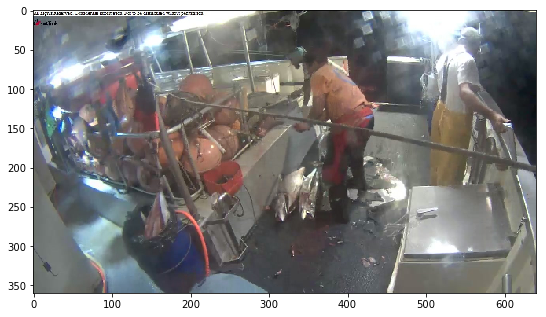

In [164]:
# view sample
plot(train_data[0])

## Precompute convolutional features

In [9]:
# Notice that we are removing the last max pooling layer since we don't want to throw away information yet

limit_mem()

# you have to specify input_shape IF you want to use with pre-computed datasets!!!
base_model = VGG19(include_top=False, input_shape=(360,640,3))
vgg640 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

In [10]:
# vgg640.summary()
vgg640.input_shape, vgg640.output_shape

((None, 360, 640, 3), (None, 22, 40, 512))

In [11]:
conv_train_feat = load_precomputed_features(preprocesed_data_path + 'conv_train_feat_vgg19_640x360.bc', vgg640, train_data, bs)
conv_val_feat = load_precomputed_features(preprocesed_data_path + 'conv_val_feat_vgg19_640x360.bc', vgg640, val_data, bs)
conv_test_feat = load_precomputed_features(preprocesed_data_path + 'conv_test_feat_vgg19_640x360.bc', vgg640, test_data, bs)

conv_train_feat_vgg19_640x360.bc loaded ...
conv_val_feat_vgg19_640x360.bc loaded ...
conv_test_feat_vgg19_640x360.bc loaded ...


In [12]:
conv_train_feat.shape

(3277, 22, 40, 512)

In [13]:
vgg640.output.shape.as_list() # = > this will be the input shape for our FCN

[None, 22, 40, 512]

## FCN

Input will be the convolutional features of VGG, the output of the vgg640 model

In [14]:
def build_fcn(input_shape, n_filters=128, p=0.0):

    inp = Input(shape=input_shape)
    x = BatchNormalization(axis=1, input_shape=input_shape)(inp)
    
    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((1,2))(x)
    
    x = Conv2D(8, (3,3), padding='same')(x)
    x = Dropout(p)(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax')(x)
    
    return Model(inputs=inp, outputs=x)

In [15]:
p = 0.0
n_filters = 128

In [16]:
limit_mem()

model = build_fcn(vgg640.output.shape.as_list()[1:], n_filters, p)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [ ]:
model.fit(conv_train_feat, train_labels, batch_size=bs, epochs=2, 
          validation_data=(conv_val_feat, val_labels))

In [ ]:
model.optimizer.lr = 1e-5

model.fit(conv_train_feat, train_labels, batch_size=bs, epochs=6, 
          validation_data=(conv_val_feat, val_labels))

In [ ]:
model.optimizer.lr = 1e-8

model.fit(conv_train_feat, train_labels, batch_size=bs, epochs=4, 
          validation_data=(conv_val_feat, val_labels))

In [17]:
# model.save_weights(models_path + '03-vgg19_640x369_fcn_weights.h5')
model.load_weights(models_path + '03-vgg19_640x369_fcn_weights.h5')

In [18]:
model.evaluate(conv_val_feat, val_labels, batch_size=bs)

500/500 [==============================] - 8s     


[0.30484544278165615, 0.95199999999999996]

The last convolutional layer has to learn to classify each part of the image.

We can create a function that grabs the output of this layer

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 22, 40, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 40, 512)       88        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 40, 128)       589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 40, 128)       88        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 20, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 20, 128)       44        
__________

In [179]:
layers = model.layers
conv_fn = K.function([layers[0].input, K.learning_phase()], [layers[-4].output])

In [180]:
def get_cm(inp, label):
    conv = conv_fn([inp, 0])[0][0][:,:,label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [187]:
inp = np.expand_dims(conv_val_feat[2], 0)
np.round(model.predict(inp)[0], 2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

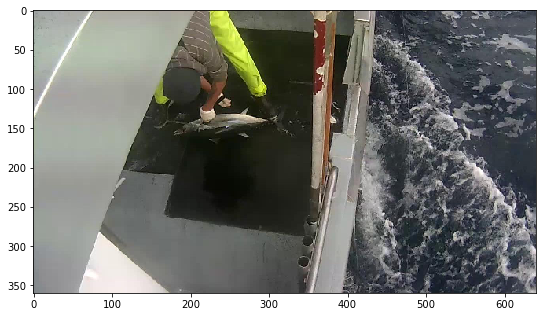

In [189]:
plt.imshow(to_plot(val_data[2]))

In [190]:
cm = get_cm(inp, 0)

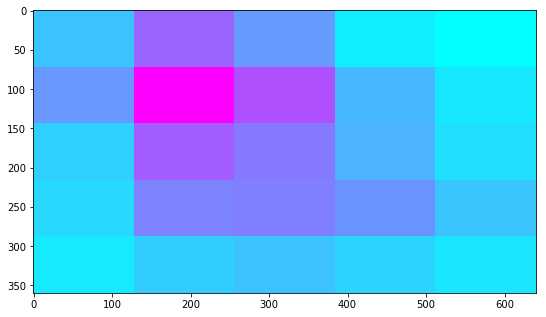

In [191]:
plt.imshow(cm, cmap="cool")]

## FCN without MaxPooling

Input will be the convolutional features of VGG, the output of the vgg640 model

In [194]:
def build_fcn_lrg(input_shape, n_filters=128, p=0.0):

    inp = Input(shape=input_shape)
    x = BatchNormalization(axis=1, input_shape=input_shape)(inp)
    
    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)

    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)

    x = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    
    x = Conv2D(8, (3,3), padding='same')(x)
    x = Dropout(p)(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax')(x)
    
    return Model(inputs=inp, outputs=x)

In [195]:
p = 0.0
n_filters = 128

limit_mem()

model_lrg = build_fcn_lrg(vgg640.output.shape.as_list()[1:], n_filters, p)
model_lrg.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [196]:
model_lrg.fit(conv_train_feat, train_labels, batch_size=bs, epochs=2, 
          validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 116s - loss: 1.1191 - acc: 0.6341 - val_loss: 0.7425 - val_acc: 0.7520
Epoch 2/2
3277/3277 [==============================] - 114s - loss: 0.4811 - acc: 0.8465 - val_loss: 0.3880 - val_acc: 0.8860


In [197]:
model_lrg.optimizer.lr = 1e-5

model_lrg.fit(conv_train_feat, train_labels, batch_size=bs, epochs=6, 
          validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 114s - loss: 0.2359 - acc: 0.9310 - val_loss: 0.3241 - val_acc: 0.9020
Epoch 2/6
3277/3277 [==============================] - 114s - loss: 0.1242 - acc: 0.9609 - val_loss: 0.2416 - val_acc: 0.9380
Epoch 3/6
3277/3277 [==============================] - 115s - loss: 0.0912 - acc: 0.9713 - val_loss: 0.3002 - val_acc: 0.9400
Epoch 4/6
3277/3277 [==============================] - 116s - loss: 0.1013 - acc: 0.9692 - val_loss: 0.2536 - val_acc: 0.9560
Epoch 5/6
3277/3277 [==============================] - 117s - loss: 0.0547 - acc: 0.9811 - val_loss: 0.2475 - val_acc: 0.9500
Epoch 6/6
3277/3277 [==============================] - 117s - loss: 0.0390 - acc: 0.9875 - val_loss: 0.1781 - val_acc: 0.9680


In [198]:
model_lrg.optimizer.lr = 1e-7

model_lrg.fit(conv_train_feat, train_labels, batch_size=bs, epochs=3, 
          validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 117s - loss: 0.0599 - acc: 0.9863 - val_loss: 0.2369 - val_acc: 0.9580
Epoch 2/3
3277/3277 [==============================] - 117s - loss: 0.0372 - acc: 0.9881 - val_loss: 0.1989 - val_acc: 0.9640
Epoch 3/3
3277/3277 [==============================] - 117s - loss: 0.0263 - acc: 0.9915 - val_loss: 0.2495 - val_acc: 0.9660


In [199]:
model_lrg.save_weights(models_path + '03-vgg19_640x369_fcn_lrg_weights.h5')
# model_lrg.load_weights(models_path + '03-vgg19_640x369_fcn_lrg_weights.h5')

In [200]:
lrg_layers = model_lrg.layers
conv_fn_lrg = K.function([lrg_layers[0].input, K.learning_phase()], [lrg_layers[-4].output])

In [201]:
def get_cm2(inp, label):
    conv = conv_fn_lrg([inp,0])[0][0][:,:,label]
    return scipy.misc.imresize(conv, (360,640))

In [270]:
model_lrg.predict(inp)[0]

array([  9.99725282e-01,   5.66981325e-05,   6.48286900e-08,
         1.14442867e-06,   1.97461925e-12,   7.68652569e-07,
         6.73307909e-10,   2.16002212e-04], dtype=float32)

In [261]:
inp = np.expand_dims(conv_val_feat[3], 0)
np.round(model_lrg.predict(inp)[0], 2)
# inp.shape

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

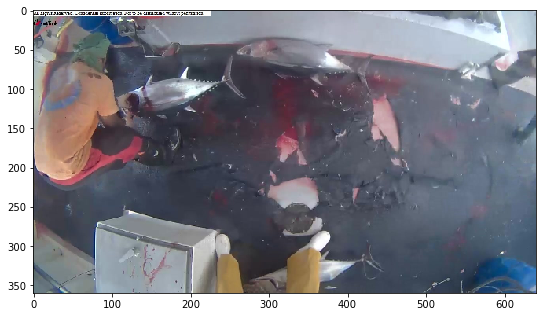

In [262]:
plt.imshow(to_plot(val_data[3]))

In [263]:
cm_0 = get_cm2(inp, 0) # the activations filter for albacore = 0
cm_4 = get_cm2(inp, 4) # the activations filter for no fish = 4
cm_1 = get_cm2(inp, 1) # the activations filter for no fish = 4

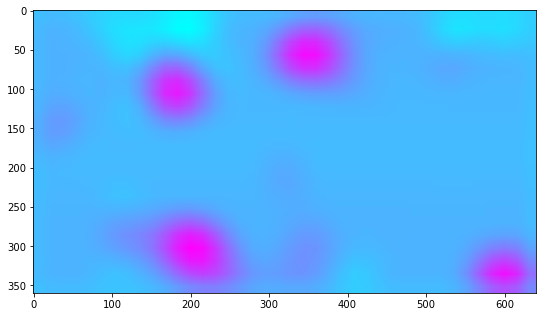

In [264]:
plt.imshow(cm_0, cmap="cool")
# plt.show()
# plt.imshow(cm_4, cmap="cool")

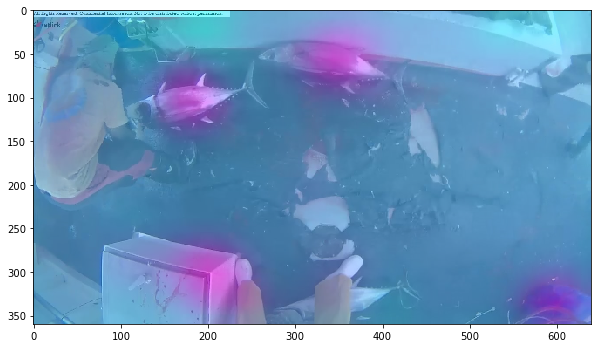

In [265]:
plt.figure(figsize=(10,10))
plot(val_data[3])
plt.imshow(cm_0, cmap="cool", alpha=0.5)

## Multi-input

Input will be the convolutional features of VGG, the output of the base model (where "include_top=False").  

Examine if we can take advantage of **data leakage** because "the images are of different sizes, which are likely to represent the boat they cam from"

In [ ]:
limit_mem()

# you have to specify input_shape IF you want to use with pre-computed datasets!!!
base_model = VGG19(include_top=False, input_shape=(224,224,3))

In [ ]:
img_sizes = [ PIL.Image.open(train_path + f).size for f in train_filenames]

In [ ]:
# the unique set of image sizes
id2size = list(set(img_sizes))
size2id = { o:i for i,o in enumerate(id2size) }

In [ ]:
import collections
collections.Counter(img_sizes)

In [ ]:
# one-hot encode size data for each image since we want to treat them as categorical
train_size_labels = to_categorical([ size2id[fsz] for fsz in img_sizes ], len(id2size))

val_img_sizes = [ PIL.Image.open(val_path + f).size for f in val_filenames ]
val_size_labels = to_categorical([ size2id[fsz] for fsz in val_img_sizes ], len(id2size))

In [ ]:
# normalize the data (BUT why?)
train_size_labels = (train_size_labels - train_size_labels.mean(axis=0)) / train_size_labels.std(axis=0)
val_size_labels = (val_size_labels - train_size_labels.mean(axis=0)) / train_size_labels.std(axis=0)

In [ ]:
# train_size_labels[0]

In [ ]:
limit_mem()

p = 0.6

inp = Input(shape=base_model.output.shape.as_list()[1:])
sz_inp = Input(shape=(len(id2size),))
bnsz_inp = BatchNormalization()(sz_inp)

x = BatchNormalization(axis=1)(inp)
x = Dropout(p / 4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(p / 2)(x)
x = concatenate([x, bnsz_inp])
preds = Dense(8, activation='softmax')(x)

model = Model(inputs=[inp, sz_inp], outputs=preds)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit([conv_train_feat, train_size_labels], train_labels, batch_size=bs, epochs=4, 
          validation_data=([conv_val_feat, val_size_labels], val_labels))

In [ ]:
model.optimizer.lr = 1e-5

model.fit([conv_train_feat, train_size_labels], train_labels, batch_size=bs, epochs=8, 
          validation_data=([conv_val_feat, val_size_labels], val_labels))

In [ ]:
model.save_weights(models_path + '02-vgg19_multi-input_weights.h5')
# model.load_weights(models_path + '02-vgg19_custom_fc_weights.h5')

## Bounding Boxes & Multi-Output

Input will be the convolutional features of VGG, the output of the base model (where "include_top=False").  

In [ ]:
bb_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [ ]:
# get the biggest annotations (some images contain multiple boxes because there are multiple fish)
bb_json = {}
for c in bb_classes:
    j = json.load(open('{}bb_annotations/{}_labels.json'.format(DATA_HOME_DIR, c), 'r'))
    for l in j:
        if('annotations' in l.keys() and len(l['annotations']) > 0):
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width']
            )[-1]

In [ ]:
bb_json['img_04908.jpg']

In [ ]:
train_file2idx = { o:i for i,o in enumerate(raw_train_filenames) }
val_file2idx = { o:i for i,o in enumerate(raw_val_filenames) }

In [ ]:
# for any images that have no annotations, we'll create an empty bounding box
empty_bbox = { 'height': 0., 'width': 0., 'x': 0., 'y': 0. }

for f in raw_train_filenames:
    if (f not in bb_json.keys()): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if (f not in bb_json.keys()): bb_json[f] = empty_bbox

In [ ]:
# convert dictionary to array and convert the coordinates to our resized 224x224 image
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [ bb[p] for p in bb_params ]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    
    return bb

In [ ]:
train_bbox = [ convert_bb(bb_json[f], s) for f,s in zip(raw_train_filenames, img_sizes) ]
train_bbox = np.stack(train_bbox).astype(np.float32)

val_bbox = [ convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, val_img_sizes) ]
val_bbox = np.stack(val_bbox).astype(np.float32)

train_bbox.shape, val_bbox.shape

In [ ]:
# check our work by drawing one of the annotations
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plt.imshow(val_data[i].astype(np.uint8))
    plt.gca().add_patch(create_rect(bb))

In [ ]:
show_bb(50)

In [ ]:
# create and train model with multiple outputs that predicts both the type of fish (the 'class') and
# the 4 bounding box coordinates

limit_mem()

p = 0.6

inp = Input(shape=base_model.output.shape.as_list()[1:])
x = BatchNormalization(axis=1)(inp)
x = Dropout(p / 4)(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p / 2)(x)

bb_preds = Dense(4, name='bb')(x)
class_preds = Dense(8, activation='softmax', name='class')(x)


In [ ]:
# for multi-ouput we need to specify what loss function to use for each and "we also weight
# the bounding-box loss function down by 1000x since the scale of cross-entropy loss and MSE is very different
model = Model(inputs=[inp], outputs=[bb_preds, class_preds])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[0.001, 1.])

In [ ]:
model.fit(conv_train_feat, [train_bbox, train_labels], batch_size=bs, epochs=3, 
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

In [ ]:
model.optimizer.lr = 1e-5

model.fit(conv_train_feat, [train_bbox, train_labels], batch_size=bs, epochs=10, 
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

In [ ]:
# get the first 10 predictions
preds = model.predict(conv_val_feat[:10])

In [ ]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = preds[0][i]
    
    plt.figure(figsize=(8,8))
    plt.imshow(val_data[i].astype(np.uint8))
    
    ax = plt.gca()
    ax.add_patch(create_rect(bb_pred, color='yellow'))
    ax.add_patch(create_rect(bb))

In [ ]:
show_bb_pred(2)

In [ ]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

In [ ]:
model.save_weights(models_path + '02-vgg19_multi-output_bb_weights.h5')
# model.load_weights(models_path + '02-vgg19_multi-output_bb_weights.h5')